# Applications of the Fourier Transform
The code and images are mostly taken from the book Brunton, S. L., & Kutz, J. N. (2019). Data-driven science and engineering: Machine learning, dynamical systems, and control. Cambridge University Press.

In [1]:
# Import libraries
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import librosa
import os

# Plotting settings
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams.update({'font.size': 11})


## Part 1: Spectrogram

### Study-case: chirp signal

Recall the quadratic chirp signal has the form

$$
x(t) = A \cos(\psi(t))
$$

where $\psi(t)$ is a quadratic function of time. For this example, let us consider 

$$
\psi(t) = f_{0} + (f_{1} - f_{0}) t^{2} / (3 t_{1}^{2})
$$

The signal $x(t)$ has the following representation in the frequency domain:

![Spectrum](img/spectrum-chirp.png)

Let us compute the spectrogram of $x(t)$

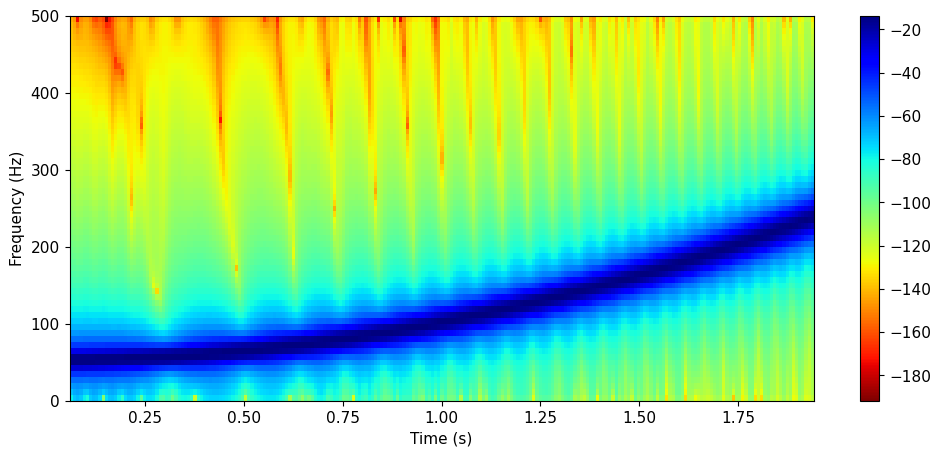

In [2]:
# Constants
dt = 0.001
t = np.arange(0, 2, dt)
f0 = 50
f1 = 250
t1 = 2
A = 1

# Create signal
x = A * np.cos(2 * np.pi * t * (f0 + (f1-f0) * np.power(t, 2) / (3*t1**2)))

# Plot signal
plt.specgram(x, NFFT=128, Fs=1/dt, noverlap=120, cmap='jet_r')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

### Study-case: Beethoven’s Sonata Pathetique

In [3]:
# Load the audio as a time series `y` and sampling rate `sr`
y, sr = librosa.load('beethoven.mp3')

print("The sampling rate is: " + str(sr) + " samples per second")
print("The number of samples in the signal are: " + str(y.shape[0]) + " samples")

The sampling rate is: 22050 samples per second
The number of samples in the signal are: 25699540 samples


In [4]:
# Plot the spectrogram
plt.specgram(y[0:1000000], NFFT=5000, Fs=sr, noverlap=400, cmap='jet_r')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\matplotlib\axes\_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Here are the first two bars of Beethoven’s Sonata Path ́ etique (No. 8 in C minor, Op. 13)

![sonata-notes](img/sonata-notes.png)

And we can localize the notes in the spectrogram

![sonata-notes](img/sonata-spectrogram.png)

## Part 2: Image Compression

### Frequency in Images

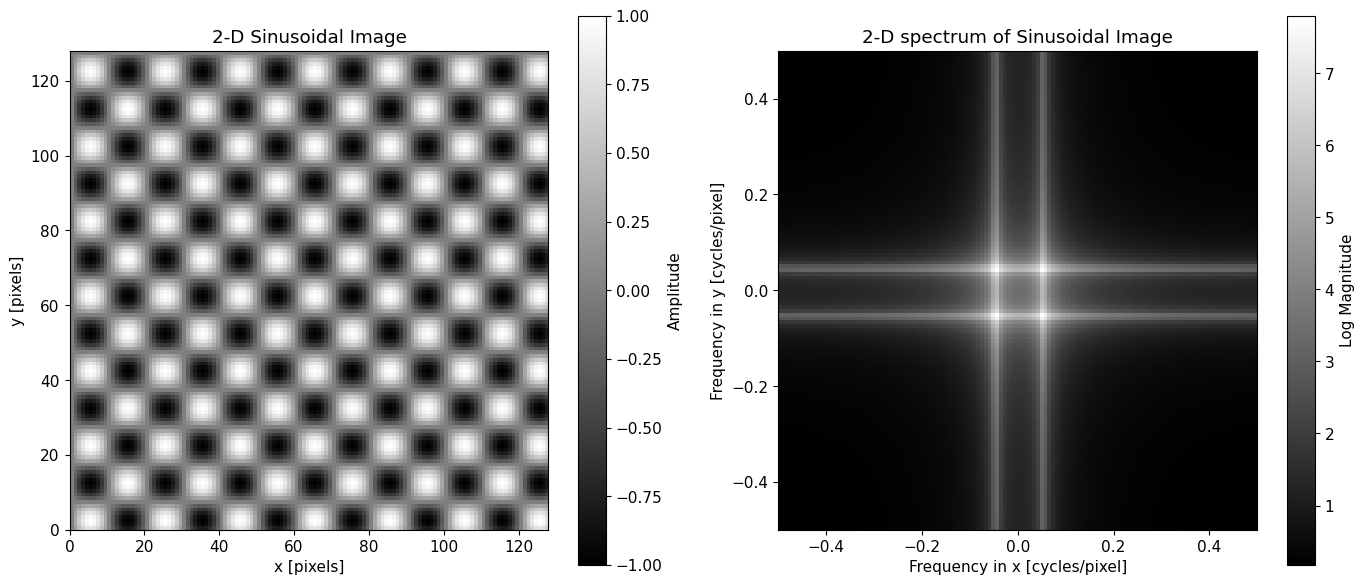

The image is a 2D sinusoidal pattern with frequencies:
freq_x =  0.05  cycles/pixel
freq_y =  0.05  cycles/pixel


In [5]:
# Image size (rows and columns)
rows, cols = 128, 128  # 256x256 pixels
freq_x = 0.05  # Frequency in x-direction (cycles per pixel)
freq_y = 0.05  # Frequency in y-direction (cycles per pixel)

# Generate the sinusoidal image
x = np.arange(0, cols)  # x-axis in pixel units
y = np.arange(0, rows)  # y-axis in pixel units
X, Y = np.meshgrid(x, y)  # Create meshgrid for pixel coordinates

# 2D sinusoidal pattern
sinusoid_image = np.sin(2 * np.pi * freq_x * X) * np.sin(2 * np.pi * freq_y * Y)

# Compute the 2D Fourier Transform and center it
fft_image = np.fft.fft2(sinusoid_image)  # Compute 2D FFT
fft_image_shifted = np.fft.fftshift(fft_image)  # Shift zero-frequency to center
magnitude_spectrum = np.abs(fft_image_shifted)  # Take magnitude for visualization

# Frequency axis for Fourier Transform
freq_x_axis = np.linspace(-0.5, 0.5, cols, endpoint=False)  
freq_y_axis = np.linspace(-0.5, 0.5, rows, endpoint=False)  

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

# Left: Sinusoidal Image
im1 = axes[0].imshow(sinusoid_image, cmap='gray', extent=[0, cols, 0, rows])
axes[0].set_title("2-D Sinusoidal Image")
axes[0].set_xlabel("x [pixels]")
axes[0].set_ylabel("y [pixels]")
fig.colorbar(im1, ax=axes[0], label="Amplitude")

# Right: Fourier Transform Magnitude Spectrum
im2 = axes[1].imshow(np.log(1 + magnitude_spectrum), cmap='gray',
                     extent=[-0.5, 0.5, -0.5, 0.5])
axes[1].set_title("2-D spectrum of Sinusoidal Image")
axes[1].set_xlabel("Frequency in x [cycles/pixel]")
axes[1].set_ylabel("Frequency in y [cycles/pixel]")
fig.colorbar(im2, ax=axes[1], label="Log Magnitude")

# Layout adjustment and display
plt.tight_layout()
plt.show()

# Print details of the image
print("The image is a 2D sinusoidal pattern with frequencies:")
print("freq_x = ", freq_x, " cycles/pixel")
print("freq_y = ", freq_y, " cycles/pixel")

### 2D FFT

We will apply first an FFT in the rows, then in the columns.

![2dfft](img/2dfft.png)

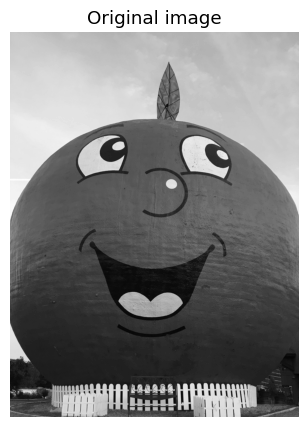

In [6]:
# Load image
A = imread(os.path.join('img', 'apple.jpg'))
B = np.mean(A, -1)  # Convert RGB to grayscale
B = np.rot90(B, k=-1)  

# Plot corrected image
plt.figure()
plt.imshow(B, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.show()

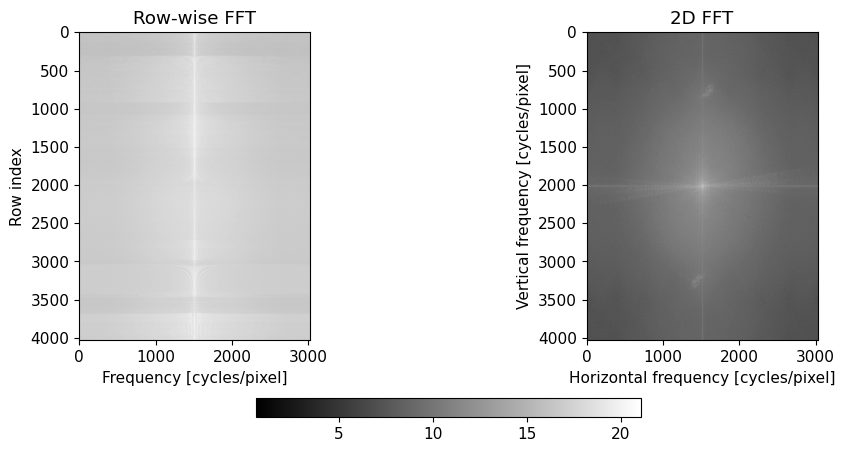

In [7]:
fig,axs = plt.subplots(1,2)

##################################################
# Compute row-wise FFT
Cshift = np.zeros_like(B,dtype='complex')
C = np.zeros_like(B,dtype='complex')

for j in range(B.shape[0]):
    # Shift the zero-frequency component to the center of the spectrum.
    Cshift[j,:] = np.fft.fftshift(np.fft.fft(B[j,:])) 

    # Compute the one-dimensional discrete Fourier Transform.
    C[j,:] = np.fft.fft(B[j,:])

img = axs[0].imshow(np.log(np.abs(Cshift)))
img.set_cmap('gray')
# axs[1].axis('off')

##################################################
# Compute column-wise FFT
D = np.zeros_like(C)
for j in range(C.shape[1]):
    # Compute the one-dimensional discrete Fourier Transform.
    D[:,j] = np.fft.fft(C[:,j])

##################################################
# Plot image
img = axs[1].imshow(np.fft.fftshift(np.log(np.abs(D)))) # Visualize FFT on log scale
img.set_cmap('gray')
# axs[2].axis('off')

# Add labels
axs[0].set_title('Row-wise FFT')
axs[1].set_title('2D FFT')

# Add colorbars
fig.colorbar(img, ax=axs, orientation='horizontal', fraction=.05)

# Add axis labels
axs[0].set_xlabel('Frequency [cycles/pixel]')
axs[0].set_ylabel('Row index')

axs[1].set_xlabel('Horizontal frequency [cycles/pixel]')
axs[1].set_ylabel('Vertical frequency [cycles/pixel]')

plt.show()

# Numpy function for the 2D FFT (More efficient)
# D = np.fft.fft2(B)

### Compression

Key idea: Let us set small Fourier coefficients to zero to create a sparse image representation that can be reconstructed faster.

C:\Users\P311985\AppData\Local\Temp\ipykernel_9904\196794734.py:31: UserWarning: Adding colorbar to a different Figure <Figure size 1200x500 with 3 Axes> than <Figure size 1200x600 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(img, ax=axs, orientation='horizontal', fraction=.05)


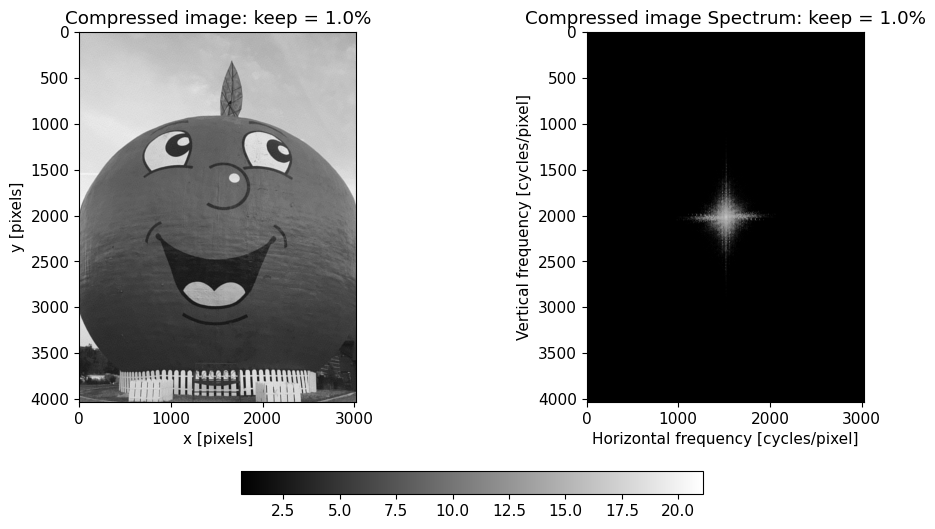

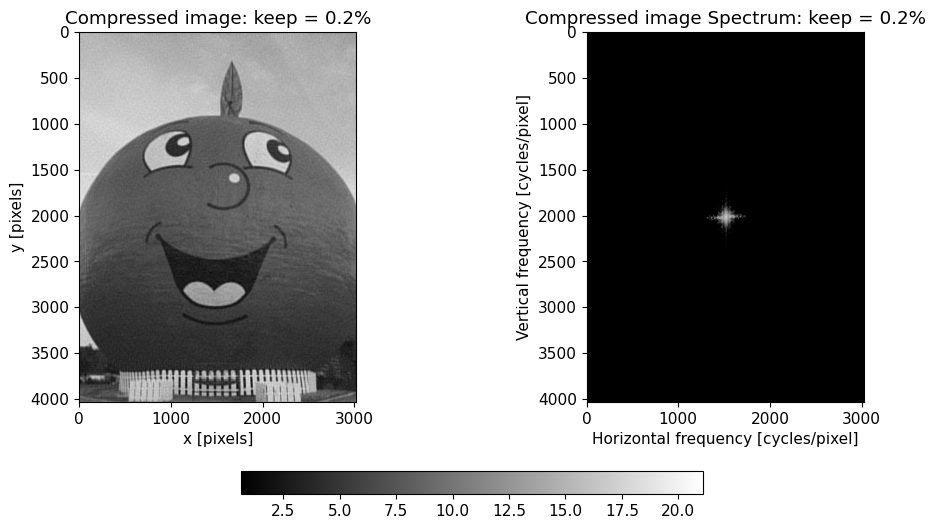

In [8]:
# 2D FFT
Bt = np.fft.fft2(B)

# Sort coefficients by magnitude
Btsort = np.sort(np.abs(Bt.reshape(-1)))

# Zero out all small coefficients and inverse transform 
# keep 10%, 5%, 1%, 0.2% largest coefficients
for keep in (0.1, 0.05, 0.01, 0.002):
    thresh = Btsort[int(np.floor((1-keep)*len(Btsort)))]
    ind = np.abs(Bt) > thresh          # Find small indices
    Btlow = Bt * ind                   # Threshold small indices

    # Use 2D iFFT to reconstruct image
    Alow = np.fft.ifft2(Btlow).real    # Compressed image
    
    # Plot compressed image and its FFT side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].imshow(Alow, cmap='gray')
    axs[0].set_xlabel('x [pixels]')
    axs[0].set_ylabel('y [pixels]')
    axs[0].set_title('Compressed image: keep = ' + str(keep * 100) + '%')
    
    axs[1].imshow(np.fft.fftshift(np.log(np.abs(Btlow) + 1)), cmap='gray')
    axs[1].set_xlabel('Horizontal frequency [cycles/pixel]')
    axs[1].set_ylabel('Vertical frequency [cycles/pixel]')
    axs[1].set_title('Compressed image Spectrum: keep = ' + str(keep * 100) + '%')
    
    # Add colorbars
    fig.colorbar(img, ax=axs, orientation='horizontal', fraction=.05)

    plt.show()



### Spectrum of AI generated images

C:\Users\P311985\AppData\Local\Temp\ipykernel_9904\710890974.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 1200x500 with 3 Axes> than <Figure size 1500x600 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(img, ax=axs, orientation='vertical', fraction=.05)


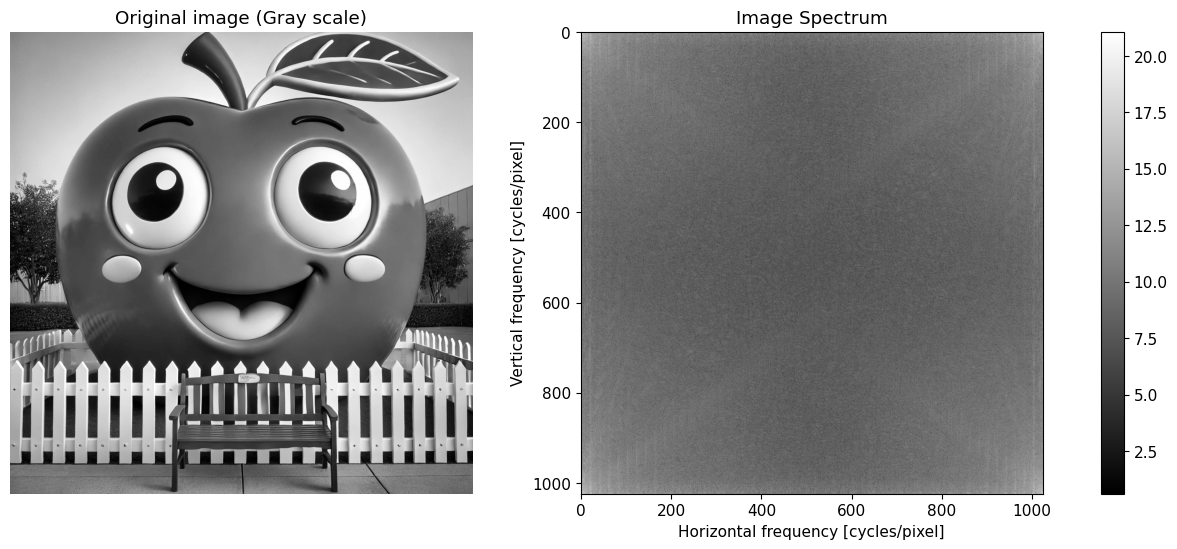

In [9]:
dalle_1 = imread(os.path.join('img','dalle-1.webp'))
dalle_1_gray = np.mean(dalle_1, -1); # Convert RGB to grayscale

# FFT of the image
dalle_1_fft = np.fft.fft2(dalle_1_gray)

# Shift the zero-frequency component to the center of the spectrum
dalle_1_fft = np.fft.fftshift(dalle_1_fft)

# Plot the image and its FFT
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].imshow(dalle_1_gray, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original image (Gray scale)')

axs[1].imshow(np.fft.fftshift(np.log(np.abs(dalle_1_fft) + 1)), cmap='gray')
axs[1].set_xlabel('Horizontal frequency [cycles/pixel]')
axs[1].set_ylabel('Vertical frequency [cycles/pixel]')
axs[1].set_title('Image Spectrum')

# Add colorbars
fig.colorbar(img, ax=axs, orientation='vertical', fraction=.05)

plt.show()


## Part 3: Denoising

### 1D case - Time-series

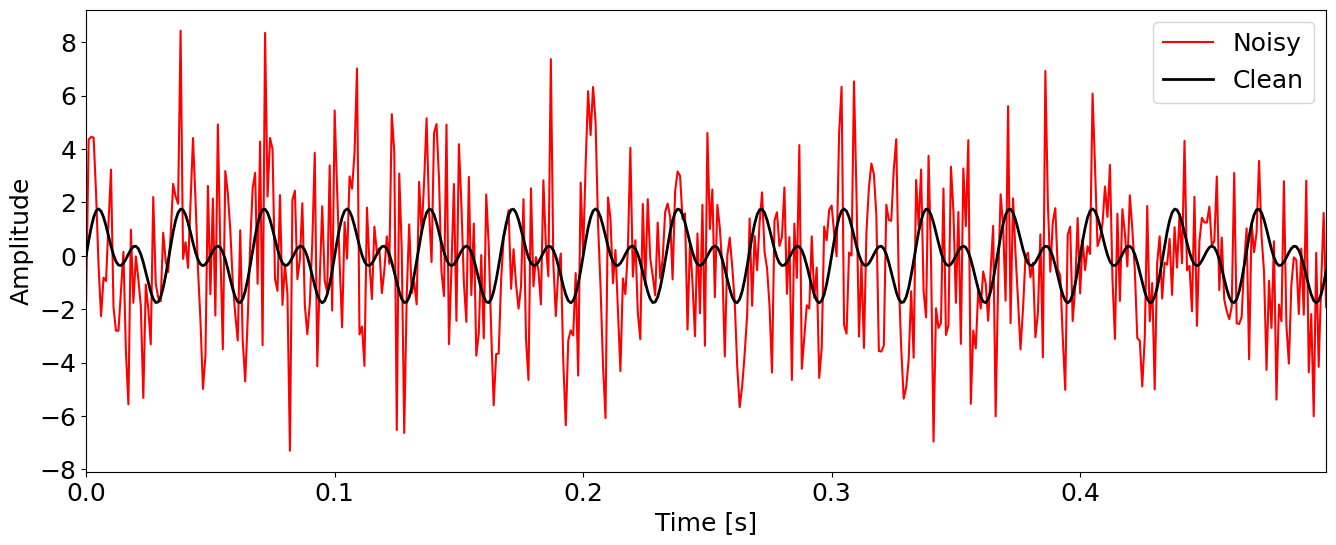

In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams.update({'font.size': 18})

# Create a simple signal with two frequencies
dt = 0.001
t = np.arange(0,0.5,dt)
f = np.sin(2 * np.pi * 30 * t) + np.sin(2 * np.pi * 60 * t) # Sum of 2 frequencies
f_clean = f

# Add some noise
f = f + 2.5*np.random.randn(len(t))

plt.plot(t,f,color='r',linewidth=1.5,label='Noisy')
plt.plot(t,f_clean,color='k',linewidth=2,label='Clean')
plt.xlim(t[0],t[-1])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


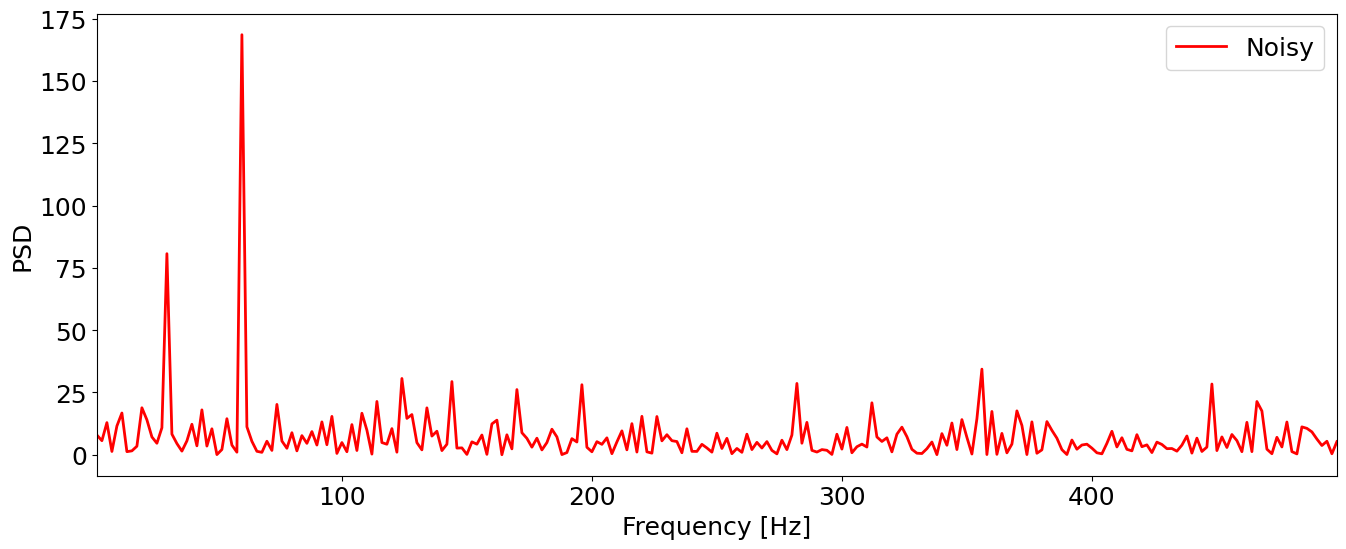

In [11]:
## Compute the Fast Fourier Transform (FFT)

n = len(t)
fhat = np.fft.fft(f,n)                     # Compute the FFT
PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq) - Magnitude of the Fourier coefficients squared
freq = (1/(dt*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
L = np.arange(1,np.floor(n/2),dtype='int') # Only plot the first half of freqs

plt.plot(freq[L],PSD[L],color='r',linewidth=2,label='Noisy')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.legend()
plt.show()

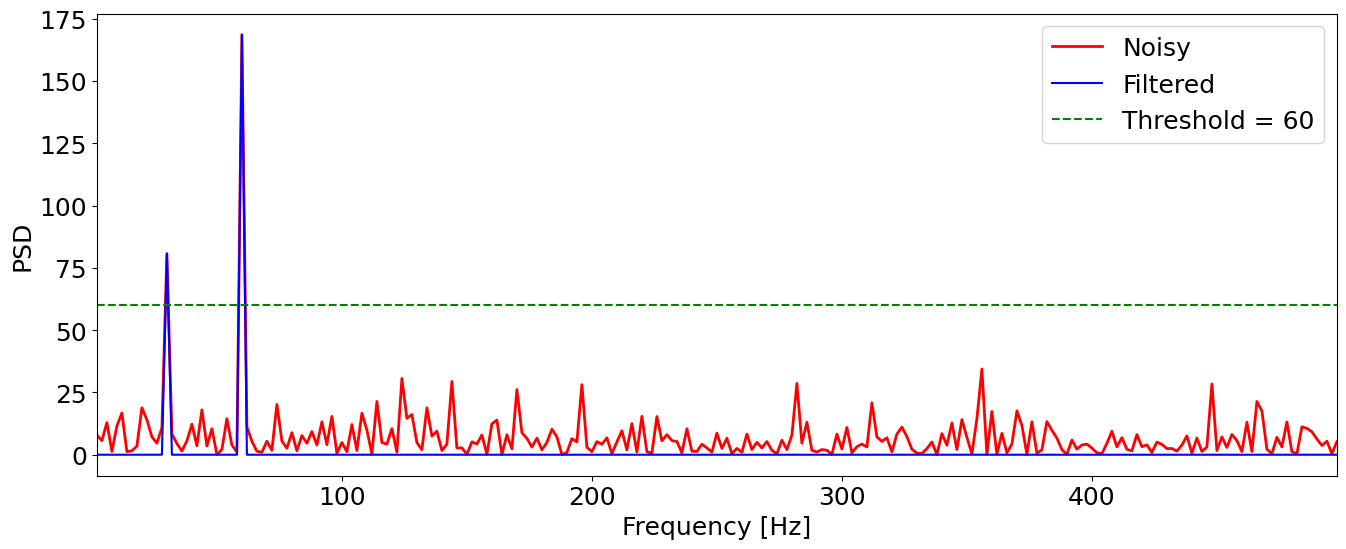

In [12]:
## Use the PSD to filter out noise
indices = PSD > 60       # Find all freqs with large power
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y

plt.plot(freq[L],PSD[L],color='r',linewidth=2,label='Noisy')
plt.plot(freq[L],PSDclean[L],color='b',linewidth=1.5,label='Filtered')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.axhline(y=60, color='g', linestyle='--', linewidth=1.5, label='Threshold = 60')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.show()

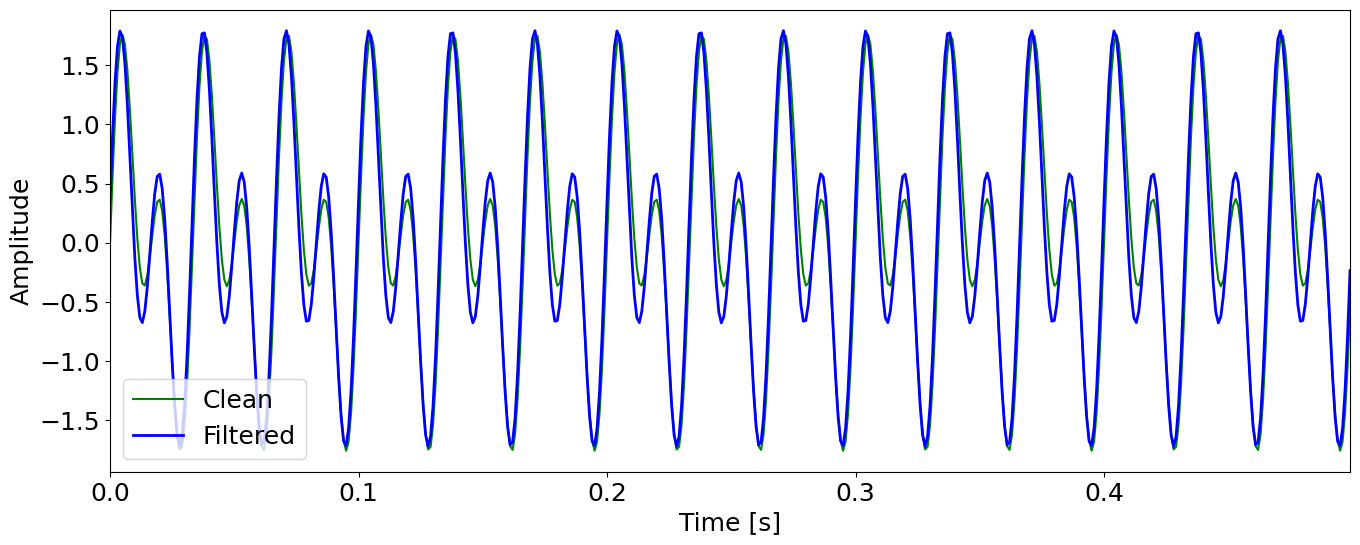

In [13]:
# Recover signal in time domain
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

plt.plot(t,f_clean,color='g',linewidth=1.5,label='Clean')
plt.plot(t,ffilt,color='b',linewidth=2,label='Filtered')
plt.xlim(t[0],t[-1])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


### Images: 2D Noise

C:\Users\P311985\AppData\Local\Temp\ipykernel_9904\3441485114.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 1200x500 with 3 Axes> than <Figure size 1600x600 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(img, ax=axs, orientation='horizontal', fraction=.05)


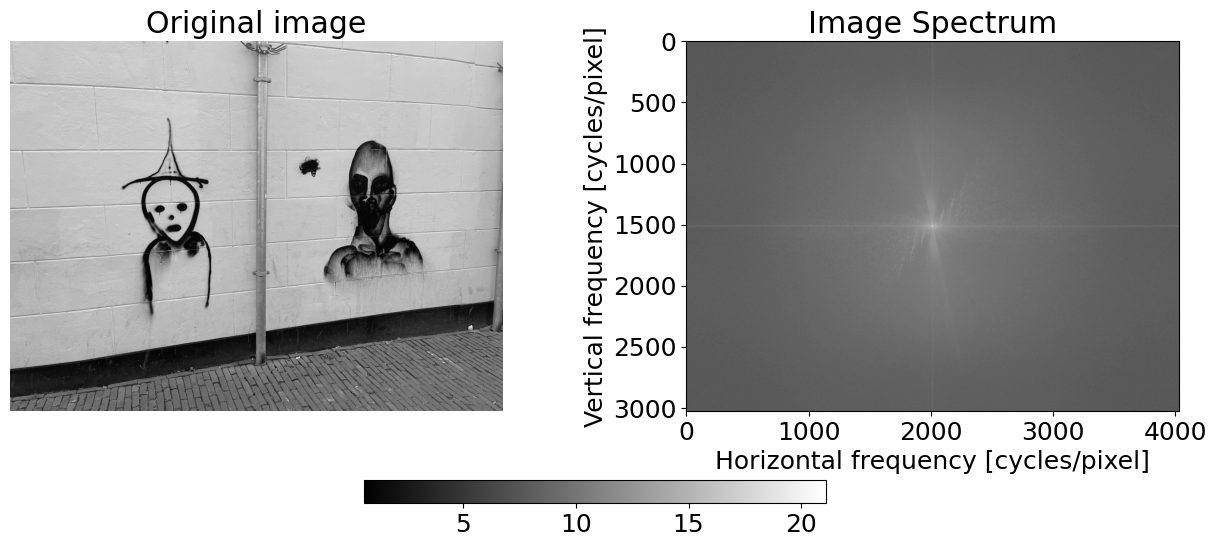

In [14]:
#Load image
A = imread(os.path.join('img','graffiti.jpg'))
B = np.mean(A, -1); # Convert RGB to grayscale

fig, axs = plt.subplots(1, 2)

# Plot original image
axs[0].imshow(B, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original image')

# Compute the 2D FFT of the image
B_fft = np.fft.fft2(B)
B_fft_shifted = np.fft.fftshift(B_fft)

# Plot the magnitude spectrum of the Fourier transform
axs[1].imshow(np.log(np.abs(B_fft_shifted) + 1), cmap='gray')
axs[1].set_xlabel('Horizontal frequency [cycles/pixel]')
axs[1].set_ylabel('Vertical frequency [cycles/pixel]')
axs[1].set_title('Image Spectrum')

# Add colorbars
fig.colorbar(img, ax=axs, orientation='horizontal', fraction=.05)

plt.show()

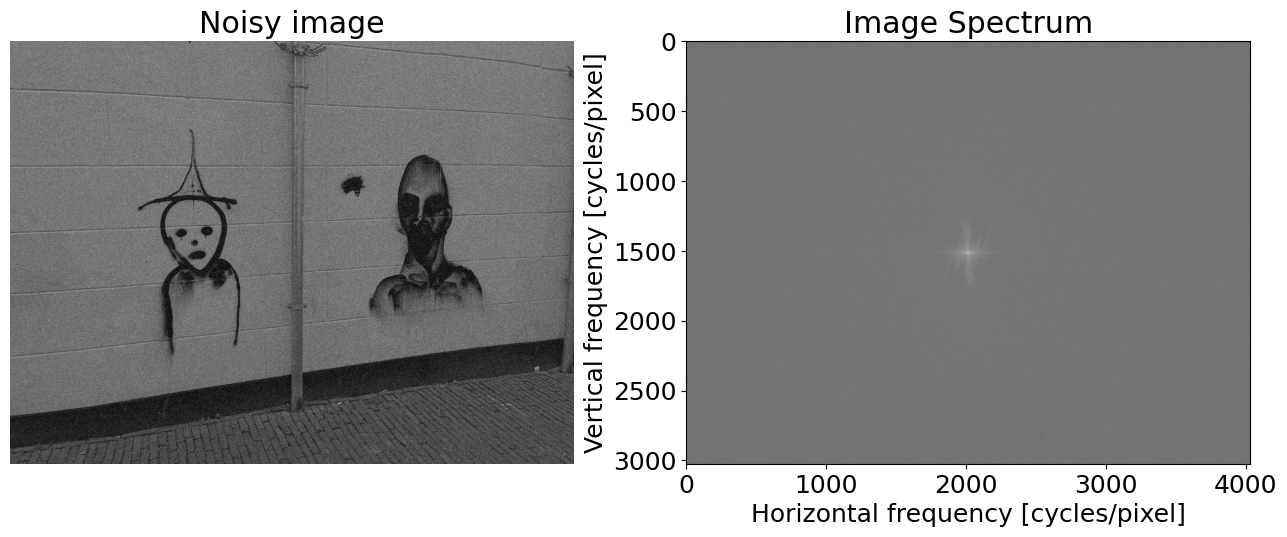

In [15]:
# Add noise to the image
Bnoise = B + 250*np.random.randn(*B.shape).astype('uint8') 

# Compute the 2D FFT of the noisy image
Bt = np.fft.fft2(Bnoise)
Btshift = np.fft.fftshift(Bt)
F = np.log(np.abs(Btshift)+1) # Put FFT on log scale

fig,axs = plt.subplots(1,2)

axs[0].imshow(Bnoise,cmap='gray')
axs[0].axis('off')
axs[0].set_title('Noisy image')

axs[1].imshow(F,cmap='gray')
axs[1].set_xlabel('Horizontal frequency [cycles/pixel]')
axs[1].set_ylabel('Vertical frequency [cycles/pixel]')
axs[1].set_title('Image Spectrum')

plt.show()

In [16]:
# Filter the image
nx,ny = B.shape

# Create a mask with ones in the center and zeros at the edges
X,Y = np.meshgrid(np.arange(-ny/2+1,ny/2+1),np.arange(-nx/2+1,nx/2+1))

# Create a circular mask
R2 = np.power(X,2) + np.power(Y,2)

# Filter the image
ind = R2 < 150**2

# Filter the image
Btshiftfilt = Btshift * ind

# Plot the magnitude spectrum of the Fourier transform
Ffilt = np.log(np.abs(Btshiftfilt)+1)

fig,axs = plt.subplots(1,2)

axs[1].imshow(Ffilt,cmap='gray')
axs[1].set_xlabel('Horizontal frequency [cycles/pixel]')
axs[1].set_ylabel('Vertical frequency [cycles/pixel]')
axs[1].set_title('Image Spectrum')

Btfilt = np.fft.ifftshift(Btshiftfilt)
Bfilt = np.fft.ifft2(Btfilt).real
axs[0].imshow(Bfilt,cmap='gray')
axs[0].axis('off')
axs[0].set_title('Filtered image')

plt.show()